In [1]:
import numpy as np
import imageio
from matplotlib import pylab as plt
import keras
%matplotlib inline

## Image Approximation

### Import image

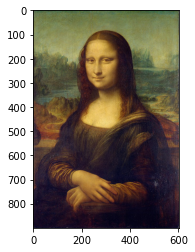

In [2]:
img = imageio.imread('./mona_lisa.jpg')
plt.imshow(img)

### Training Set

In [3]:
def RandomSampling(image, N):
    y_rand = np.random.choice(img.shape[0], size=N, replace=True)
    x_rand = np.random.choice(img.shape[1], size=N, replace=True)

    img_masked = np.ones(img.shape)
    points = []
    intensities = []

    for i in range(N):
        # get random coordinate (y,x)
        point = (y_rand[i], x_rand[i])
        # get pixel intensity at the correspondng location
        # rescale to lie between 0.0 and 1.0
        intensity = img[point]/255.0
        points.append(point)
        intensities.append(intensity)
        img_masked[point] = intensity
    return points, intensities, img_masked

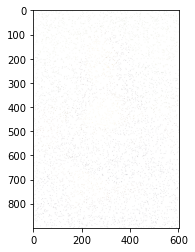

In [4]:
X_train, y_train, img_masked = RandomSampling(img, 5000)
plt.imshow(img_masked)

### Testing Set
Build testing set with all possible coordinates on the image

In [5]:
X_test = []
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        coord = np.array([y,x])
        X_test.append(coord)

### Random Forest Implementation

In [6]:
from sklearn.ensemble import RandomForestRegressor

#### Create model

In [7]:
model = RandomForestRegressor(n_estimators=1)

#### Train model

In [8]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1)

#### Make predictions

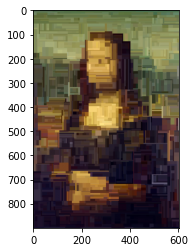

In [9]:
y_pred = model.predict(X_test).reshape(img.shape)
plt.imshow(y_pred)

### Variable depth

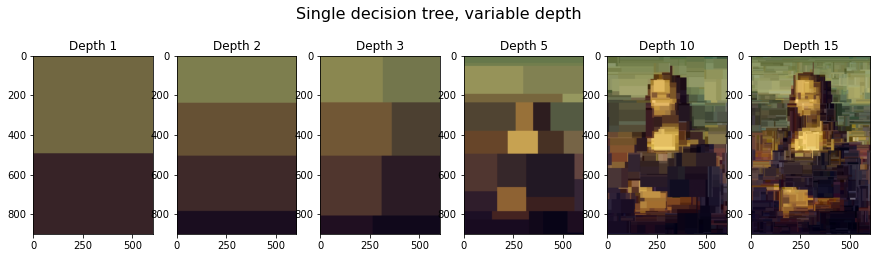

In [10]:
depths = [1, 2, 3, 5, 10, 15]

fig, axs = plt.subplots(1,3,figsize=(15,4))
for i, depth in enumerate(depths):
    model = RandomForestRegressor(n_estimators=1, max_depth = depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).reshape(img.shape)
    ax = plt.subplot(1,6,i+1)
    plt.imshow(y_pred)
    plt.title("Depth " + str(depth))
fig.suptitle("Single decision tree, variable depth", fontsize=16)
plt.show()

### Variable number of trees
Repeat the experiment for a random forest of depth 7,but with number of trees equalto 1, 3, 5, 10, and 100. 

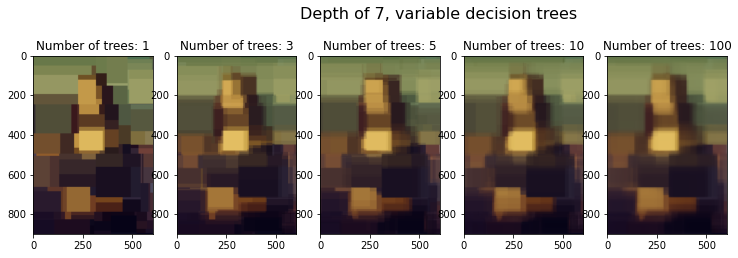

In [11]:
trees = [1, 3, 5, 10, 100]

fig, axs = plt.subplots(1,3,figsize=(15,4))
for i, tree in enumerate(trees):
    model = RandomForestRegressor(n_estimators=tree, max_depth= 7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).reshape(img.shape)
    ax = plt.subplot(1,6,i+1)
    plt.imshow(y_pred)
    plt.title("Number of trees: " + str(tree))
fig.suptitle("Depth of 7, variable decision trees", fontsize=16)
plt.show()

### k-NN regressor as baseline

In [12]:
from sklearn.neighbors import KNeighborsRegressor

#### Create model

In [13]:
model = KNeighborsRegressor(n_neighbors=1)

#### Train model

In [14]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

#### Make predictions

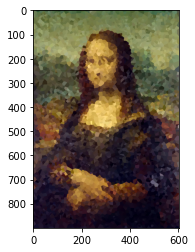

In [15]:
y_pred = model.predict(X_test).reshape(img.shape)
plt.imshow(y_pred)

### More pruning


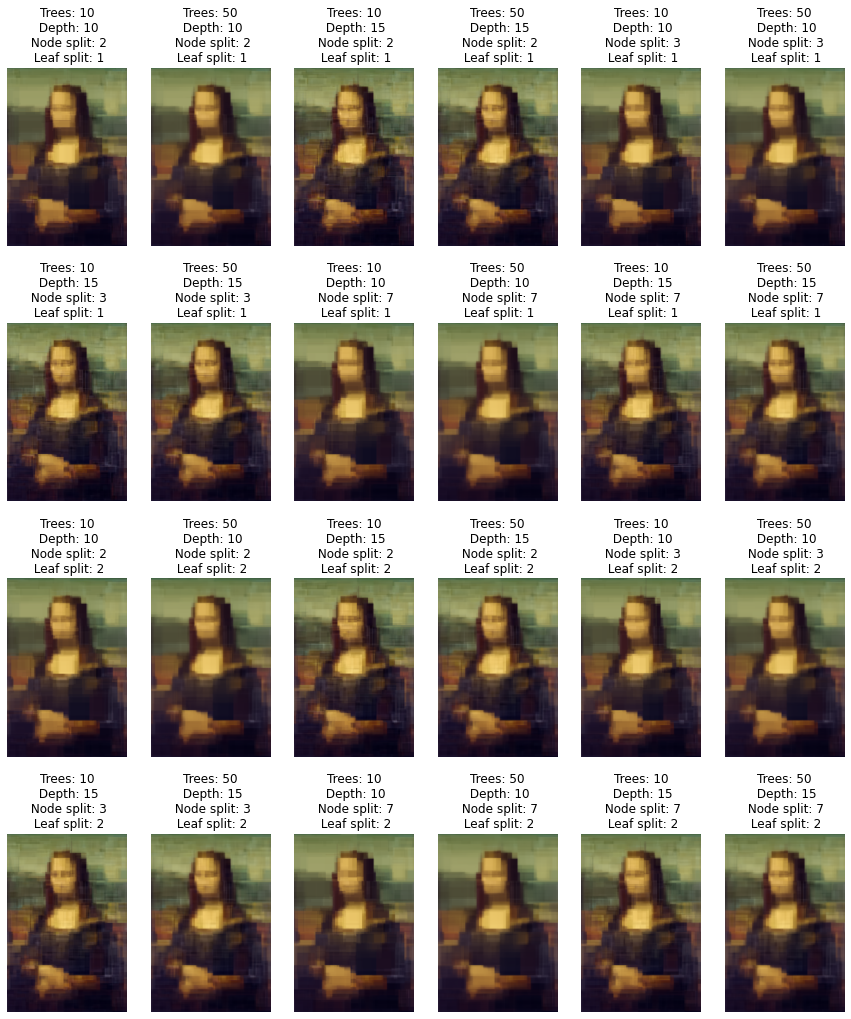

In [16]:
trees = [10, 50]
depths = [10, 15]
node_splits = [2, 3, 7]
leaf_splits = [1, 2]

fig, axs = plt.subplots(1,15,figsize=(15,18))
counter = 0
for leaf_split in leaf_splits:
    for node_split in node_splits:
        for depth in depths:
            for tree in trees:
                model = RandomForestRegressor(n_estimators=tree, 
                                              max_depth= depth, 
                                              min_samples_split=node_split,
                                              min_samples_leaf=leaf_split)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test).reshape(img.shape)
                counter+=1
                ax = plt.subplot(4, 6,counter)
                plt.axis('off')
                plt.imshow(y_pred)
                plt.title("Trees: "+ str(tree) + 
                          "\n Depth: " + str(depth) + 
                          "\n Node split: " + str(node_split) +
                          "\n Leaf split: " + str(leaf_split))
        
plt.show()

## Analysis

#### Decision rule 

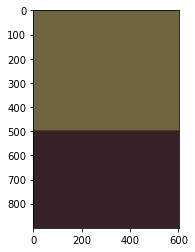

In [17]:
model = RandomForestRegressor(n_estimators=1, max_depth=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test).reshape(img.shape)
plt.imshow(y_pred)

In [18]:
value1 = y_pred[0,0]
value2 = y_pred[y_pred.shape[0]-1,y_pred.shape[1]-1]
split_point = int(model.estimators_[0].tree_.threshold[0])
print("Split point: " + str(split_point))
print("Lower value: " + str(value1))
print("Upper value: " + str(value2))

Split point: 496
Lower value: [0.43890919 0.39823762 0.2520121 ]
Upper value: [0.21829575 0.14111399 0.15451238]


$$ im(y,x) = \begin{cases}\text{[0.449, 0.416, 0.264]} & \text{if } y_j \leq 482 \\ \text{[0.214, 0.138, 0.155]} & \text{if } y_j > 482 \end{cases} $$